In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

c:\Users\vibal\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.32, 0.08, 0.6)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [6]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [7]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 30/30 [01:51<00:00,  3.71s/it]


#### Results

In [8]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 550/550 [00:17<00:00, 31.30it/s]


In [9]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.38679761463482526,
 'epoch': 30,
 'train_loss': 0.04167158,
 'val_loss': 0.05092112,
 'train_acc': 0.49791666865348816,
 'val_acc': 0.49166664481163025,
 'val_rmse_perc': 0.2273177,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.49_2023-03-30_21.34.53.217976',
 'train_rmse': 0.8862373647430279,
 'val_rmse': 0.8990735972840785,
 'test_rmse': 0.8881941729649485,
 'train_mae': 0.59375,
 'val_mae': 0.6083333333333333,
 'test_mae': 0.5911111111111111,
 'train_mcc': 0.3749059488103034,
 'test_mcc': 0.38889263451808587,
 'test_acc': 0.5055555701255798,
 'train_rmse_perc': 0.21583025,
 't

In [10]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.32217965168185103,
 'epoch': 50,
 'train_loss': 0.0384381,
 'val_loss': 0.03363439,
 'train_acc': 0.5062500238418579,
 'val_acc': 0.47499996423721313,
 'val_rmse_perc': 0.1877307,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.47_2023-03-30_21.34.19.738794_50',
 'train_rmse': 0.8139410298049853,
 'val_rmse': 0.806225774829855,
 'test_rmse': 0.8299933065325822,
 'train_mae': 0.55,
 'val_mae': 0.5666666666666667,
 'test_mae': 0.5755555555555556,
 'train_mcc': 0.36110696970354456,
 'test_mcc': 0.3202837602431622,
 'test_acc': 0.47999998927116394,
 'train_rmse_perc': 0.19052072,
 

In [11]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.31672905248477057,
 'epoch': 100,
 'train_loss': 0.038049422,
 'val_loss': 0.034446627,
 'train_acc': 0.5,
 'val_acc': 0.47499996423721313,
 'val_rmse_perc': 0.18978104,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.47_2023-03-30_21.34.19.738794_100',
 'train_rmse': 0.8177713616898062,
 'val_rmse': 0.806225774829855,
 'test_rmse': 0.8319989316232457,
 'train_mae': 0.55625,
 'val_mae': 0.5666666666666667,
 'test_mae': 0.5788888888888889,
 'train_mcc': 0.3517218799829905,
 'test_mcc': 0.31331128687509674,
 'test_acc': 0.476666659116745,
 'train_rmse_perc': 0.19031946,
 'test_rm

In [12]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 550/550 [00:00<00:00, 23643.69it/s]


In [13]:
cm = all[sort_idx[0]]['test_cm'][0]

In [14]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

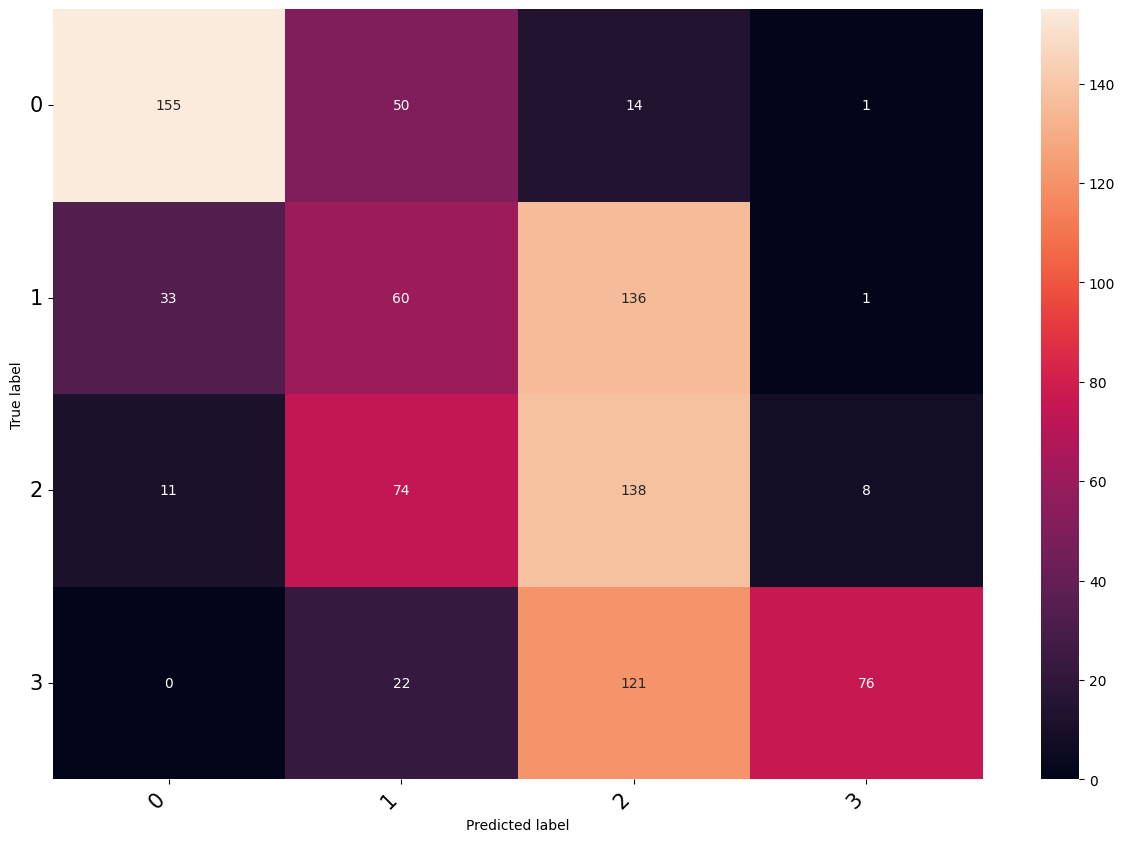

In [15]:
cm.visualize()

In [16]:
cm.class_accuracy

tensor([0.7045, 0.2609, 0.5974, 0.3470])

In [17]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.18322606, 0.20501718, 0.1569776, 0.223262]

In [18]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.14386964, 0.17902185, 0.12633762, 0.19734439]

### GCN

In [19]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [20]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [05:57<00:00,  4.96s/it]


#### Results

In [21]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1190/1190 [01:17<00:00, 15.45it/s]


In [22]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.34555620926691455,
 'epoch': 100,
 'train_loss': 0.026910115,
 'val_loss': 0.04248635,
 'train_acc': 0.6395833492279053,
 'val_acc': 0.4999999701976776,
 'val_rmse_perc': 0.21052678,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.50_2023-03-30_21.38.18.733205_100',
 'train_rmse': 0.6454972243679028,
 'val_rmse': 0.8465616732800196,
 'test_rmse': 0.7272474743090476,
 'train_mae': 0.37916666666666665,
 'val_mae': 0.5666666666666667,
 'test_mae': 0.42,
 'train_mcc': 0.533593733747212,
 'test_mcc': 0.5134244689318022,
 'test_acc': 0.6299999952316284,
 'train_r

In [23]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4033245258310579,
 'epoch': 100,
 'train_loss': 0.031911835,
 'val_loss': 0.029130787,
 'train_acc': 0.5562499761581421,
 'val_acc': 0.5249999761581421,
 'val_rmse_perc': 0.17660473,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.52_2023-03-30_21.35.55.129846_100',
 'train_rmse': 0.7026734661277598,
 'val_rmse': 0.7071067811865476,
 'test_rmse': 0.7287737036358481,
 'train_mae': 0.46041666666666664,
 'val_mae': 0.48333333333333334,
 'test_mae': 0.4688888888888889,
 'train_mcc': 0.43929417331741205,
 'test_mcc': 0.4406894490168838,
 'test_acc': 0.5611110925

In [24]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.40195030602537957,
 'epoch': 100,
 'train_loss': 0.027516402,
 'val_loss': 0.046163537,
 'train_acc': 0.6291666626930237,
 'val_acc': 0.5416666269302368,
 'val_rmse_perc': 0.22272934,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.54_2023-03-30_21.39.55.746036_100',
 'train_rmse': 0.6677075208003377,
 'val_rmse': 0.8465616732800196,
 'test_rmse': 0.7,
 'train_mae': 0.3958333333333333,
 'val_mae': 0.5333333333333333,
 'test_mae': 0.41444444444444445,
 'train_mcc': 0.5186109250692492,
 'test_mcc': 0.502280264013642,
 'test_acc': 0.6211110949516296,
 'trai

In [25]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1190/1190 [00:00<00:00, 28611.84it/s]


### GraphSAGE

In [26]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [27]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 144/144 [1:14:51<00:00, 31.19s/it]


#### Results

In [28]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 4025/4025 [10:14<00:00,  6.55it/s]


In [29]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7672198049098212,
 'epoch': 80,
 'train_loss': 0.0018600997,
 'val_loss': 0.0078117643,
 'train_acc': 0.9750000238418579,
 'val_acc': 0.8249999284744263,
 'val_rmse_perc': 0.07807372,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.82_2023-03-30_22.54.13.841927_80',
 'train_rmse': 0.15811388300841897,
 'val_rmse': 0.4183300132670378,
 'test_rmse': 0.4654746681256314,
 'train_mae': 0.025,
 'val_mae': 0.175,
 'test_mae': 0.1988888888888889,
 'train_mcc': 0.9666628151390576,
 'test_mcc': 0.7439421131203788,
 'test_acc': 0.80

In [30]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8232463592982684,
 'epoch': 90,
 'train_loss': 0.0039668838,
 'val_loss': 0.0067782626,
 'train_acc': 0.9458333253860474,
 'val_acc': 0.8666666150093079,
 'val_rmse_perc': 0.06509194,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.87_2023-03-30_22.36.46.564492_90',
 'train_rmse': 0.2327373340628157,
 'val_rmse': 0.3651483716701107,
 'test_rmse': 0.47842333648024415,
 'train_mae': 0.05416666666666667,
 'val_mae': 0.13333333333333333,
 'test_mae': 0.21555555555555556,
 'train_mcc': 0.9285559909255632,
 'test_mcc': 0.72216

In [31]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7890882833618471,
 'epoch': 56,
 'train_loss': 0.0037485906,
 'val_loss': 0.0084467875,
 'train_acc': 0.956250011920929,
 'val_acc': 0.8416666388511658,
 'val_rmse_perc': 0.0784975,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.84_2023-03-30_22.49.40.721795',
 'train_rmse': 0.2091650066335189,
 'val_rmse': 0.39791121287711073,
 'test_rmse': 0.469041575982343,
 'train_mae': 0.04375,
 'val_mae': 0.15833333333333333,
 'test_mae': 0.2088888888888889,
 'train_mcc': 0.9417207610831949,
 'test_mcc': 0.7278411975950755,
 'test

In [32]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 4025/4025 [00:00<00:00, 27006.00it/s]


#### cm

In [33]:
cm = all[sort_idx[0]]['test_cm'][0]

In [34]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

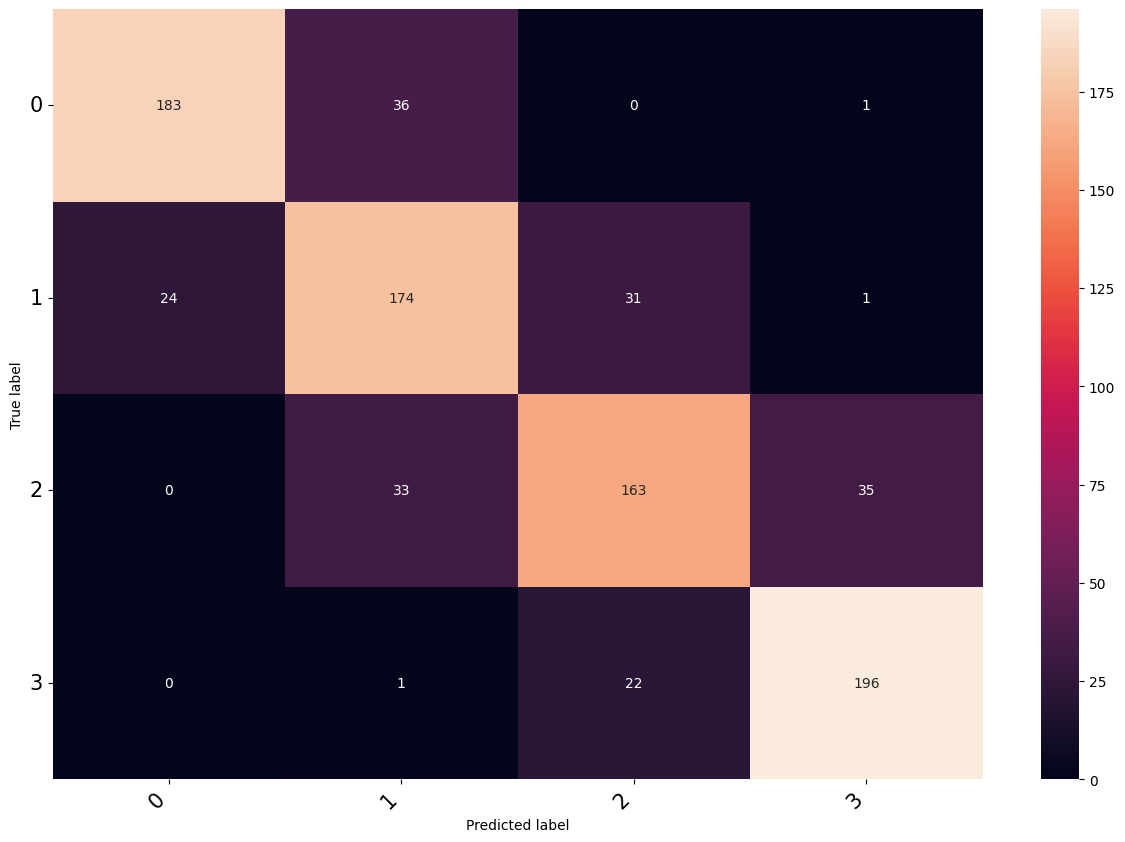

In [35]:
cm.visualize()

In [36]:
cm.class_accuracy

tensor([0.8318, 0.7565, 0.7056, 0.8950])

In [37]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.08288079, 0.08707018, 0.08948341, 0.08601995]

In [38]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.05617288, 0.06195351, 0.06816564, 0.061292578]

#### GraphSAGE Base_n

In [39]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [40]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='base_n',
        )

100%|██████████| 144/144 [1:23:46<00:00, 34.91s/it]


##### Results

In [41]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='base_n',
)

100%|██████████| 2773/2773 [06:49<00:00,  6.77it/s]


In [42]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6961838397918007,
 'epoch': 59,
 'train_loss': 0.0041528195,
 'val_loss': 0.015650231,
 'train_acc': 0.8229166865348816,
 'val_acc': 0.76666659116745,
 'val_rmse_perc': 0.10168174,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.77_2023-03-30_23.25.34.606630',
 'train_rmse': 0.4208127057650866,
 'val_rmse': 0.48304589153964794,
 'test_rmse': 0.4910306620885412,
 'train_mae': 0.17708333333333334,
 'val_mae': 0.23333333333333334,
 'test_mae': 0.23,
 'train_mcc': 0.7704553717543353,
 'test_mcc': 0.7010110693664554,
 'test

In [43]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6961838397918007,
 'epoch': 59,
 'train_loss': 0.0041528195,
 'val_loss': 0.015650231,
 'train_acc': 0.8229166865348816,
 'val_acc': 0.76666659116745,
 'val_rmse_perc': 0.10168174,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.77_2023-03-30_23.25.34.606630',
 'train_rmse': 0.4208127057650866,
 'val_rmse': 0.48304589153964794,
 'test_rmse': 0.4910306620885412,
 'train_mae': 0.17708333333333334,
 'val_mae': 0.23333333333333334,
 'test_mae': 0.23,
 'train_mcc': 0.7704553717543353,
 'test_mcc': 0.7010110693664554,
 'test

In [44]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6961838397918007,
 'epoch': 59,
 'train_loss': 0.0041528195,
 'val_loss': 0.015650231,
 'train_acc': 0.8229166865348816,
 'val_acc': 0.76666659116745,
 'val_rmse_perc': 0.10168174,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.77_2023-03-30_23.25.34.606630',
 'train_rmse': 0.4208127057650866,
 'val_rmse': 0.48304589153964794,
 'test_rmse': 0.4910306620885412,
 'train_mae': 0.17708333333333334,
 'val_mae': 0.23333333333333334,
 'test_mae': 0.23,
 'train_mcc': 0.7704553717543353,
 'test_mcc': 0.7010110693664554,
 'test

In [45]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2773/2773 [00:00<00:00, 26279.67it/s]


##### cm

In [46]:
cm = all[sort_idx[0]]['test_cm'][0]

In [47]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

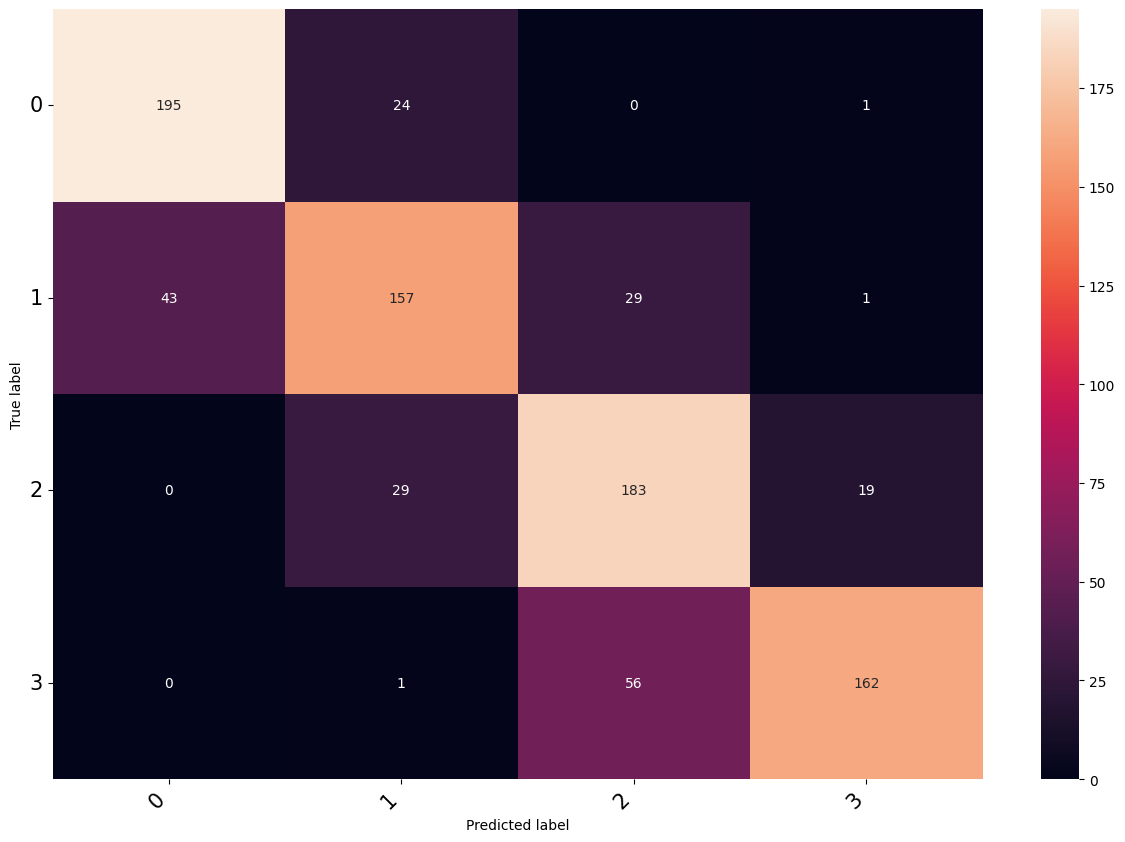

In [48]:
cm.visualize()

In [49]:
cm.class_accuracy

tensor([0.8864, 0.6826, 0.7922, 0.7397])

In [50]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.08365558, 0.100747615, 0.07485438, 0.1431022]

In [51]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.06253841, 0.07755158, 0.05689157, 0.122098826]

#### GraphSAGE Scale

In [52]:
save_model = f'{save_path}_sage_scale'
log_dir = f'{log_path}_sage_scale'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [53]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='scale',
        )

100%|██████████| 144/144 [1:21:26<00:00, 33.94s/it]


##### Results

In [54]:
res_edges_sage_dist = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='scale',
)

100%|██████████| 3767/3767 [09:17<00:00,  6.76it/s]


In [55]:
res_edges = res_edges_sage_dist
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7732224760511508,
 'epoch': 71,
 'train_loss': 0.0070222574,
 'val_loss': 0.014448856,
 'train_acc': 0.9145833253860474,
 'val_acc': 0.8249999284744263,
 'val_rmse_perc': 0.098472156,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.82_2023-03-31_01.52.32.317227',
 'train_rmse': 0.29226129861250305,
 'val_rmse': 0.4183300132670378,
 'test_rmse': 0.4630814663149935,
 'train_mae': 0.08541666666666667,
 'val_mae': 0.175,
 'test_mae': 0.1988888888888889,
 'train_mcc': 0.8886122720522943,
 'test_mcc': 0.7521343353043258,
 't

In [56]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7454110534319268,
 'epoch': 55,
 'train_loss': 0.009648407,
 'val_loss': 0.0139767295,
 'train_acc': 0.862500011920929,
 'val_acc': 0.7999999523162842,
 'val_rmse_perc': 0.09539192,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.80_2023-03-31_01.52.32.317227',
 'train_rmse': 0.37080992435478316,
 'val_rmse': 0.4472135954999579,
 'test_rmse': 0.5163977794943222,
 'train_mae': 0.1375,
 'val_mae': 0.2,
 'test_mae': 0.2511111111111111,
 'train_mcc': 0.8216429396220848,
 'test_mcc': 0.6854485918947825,
 'test_acc': 0.75555

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7732224760511508,
 'epoch': 71,
 'train_loss': 0.0070222574,
 'val_loss': 0.014448856,
 'train_acc': 0.9145833253860474,
 'val_acc': 0.8249999284744263,
 'val_rmse_perc': 0.098472156,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.82_2023-03-31_01.52.32.317227',
 'train_rmse': 0.29226129861250305,
 'val_rmse': 0.4183300132670378,
 'test_rmse': 0.4630814663149935,
 'train_mae': 0.08541666666666667,
 'val_mae': 0.175,
 'test_mae': 0.1988888888888889,
 'train_mcc': 0.8886122720522943,
 'test_mcc': 0.7521343353043258,
 't

In [58]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3767/3767 [00:00<00:00, 23937.35it/s]


##### cm

In [59]:
cm = all[sort_idx[0]]['test_cm'][0]

In [60]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

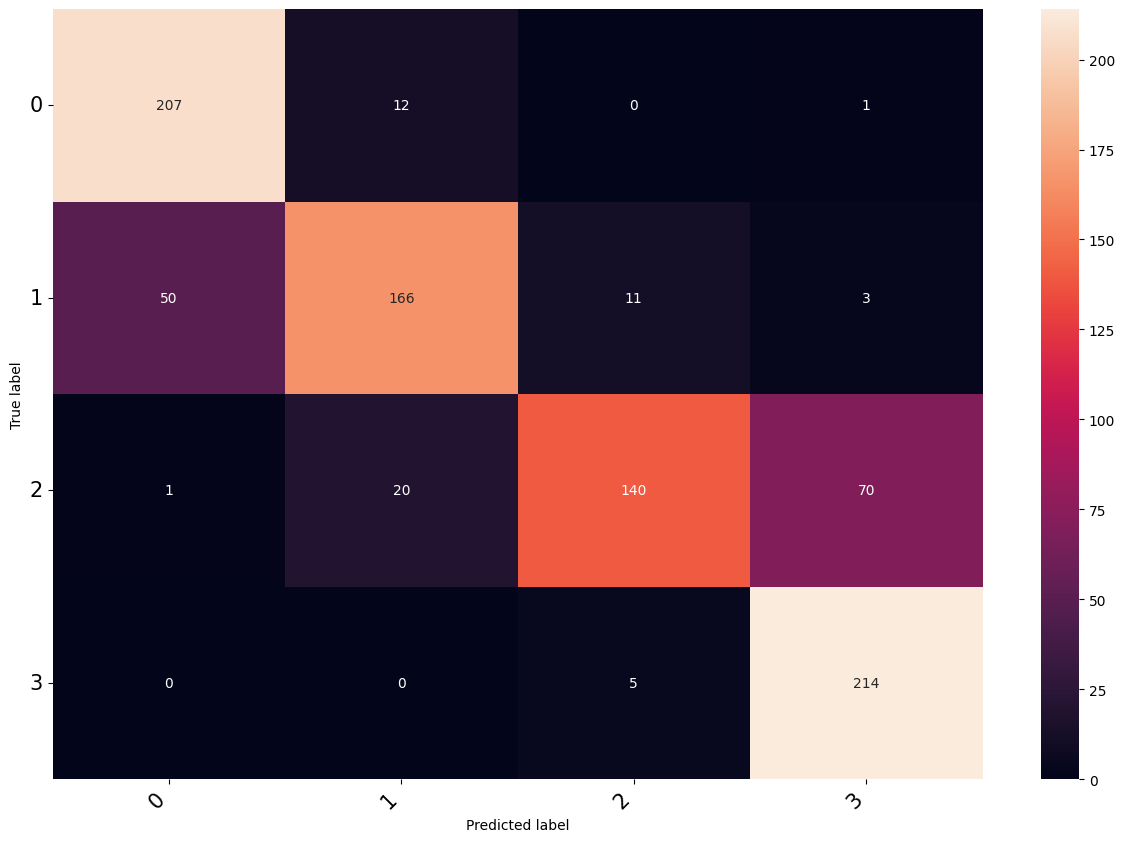

In [61]:
cm.visualize()

In [62]:
cm.class_accuracy

tensor([0.9409, 0.7217, 0.6061, 0.9772])

In [63]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.10184891, 0.10861495, 0.123974875, 0.093639135]

In [64]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.077107206, 0.07493878, 0.09071536, 0.07617982]

### GAT

In [65]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [66]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [26:13<00:00,  5.46s/it]


#### Results

In [67]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 4470/4470 [03:52<00:00, 19.23it/s]


In [68]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3816788277537618,
 'epoch': 100,
 'train_loss': 0.036763392,
 'val_loss': 0.036767878,
 'train_acc': 0.6312500238418579,
 'val_acc': 0.5333333015441895,
 'val_rmse_perc': 0.19548106,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.53_2023-03-31_02.35.23.053260_100',
 'train_rmse': 0.6661456297237114,
 'val_rmse': 0.8416254115301732,
 'test_rmse': 0.7564537145273478,
 'train_mae': 0.39375,
 'val_mae': 0.5416666666666666,
 'test_mae': 0.47,
 'train_mcc': 0.5196072909195565,
 'test_mcc': 0.4431492062

In [69]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3816788277537618,
 'epoch': 100,
 'train_loss': 0.036763392,
 'val_loss': 0.036767878,
 'train_acc': 0.6312500238418579,
 'val_acc': 0.5333333015441895,
 'val_rmse_perc': 0.19548106,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.53_2023-03-31_02.35.23.053260_100',
 'train_rmse': 0.6661456297237114,
 'val_rmse': 0.8416254115301732,
 'test_rmse': 0.7564537145273478,
 'train_mae': 0.39375,
 'val_mae': 0.5416666666666666,
 'test_mae': 0.47,
 'train_mcc': 0.5196072909195565,
 'test_mcc': 0.4431492062

In [70]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3816788277537618,
 'epoch': 100,
 'train_loss': 0.036763392,
 'val_loss': 0.036767878,
 'train_acc': 0.6312500238418579,
 'val_acc': 0.5333333015441895,
 'val_rmse_perc': 0.19548106,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.53_2023-03-31_02.35.23.053260_100',
 'train_rmse': 0.6661456297237114,
 'val_rmse': 0.8416254115301732,
 'test_rmse': 0.7564537145273478,
 'train_mae': 0.39375,
 'val_mae': 0.5416666666666666,
 'test_mae': 0.47,
 'train_mcc': 0.5196072909195565,
 'test_mcc': 0.4431492062

In [71]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 4470/4470 [00:00<00:00, 22445.65it/s]
